# The quintic Ornstein-Uhlenbeck volatility model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import ImpliedDrift as iD
import time
import Quintic

from scipy.optimize import least_squares as ls
from matplotlib import cm

In [2]:
spot = np.array(pd.read_csv("spot.csv").Spot)
index = 0
S0 = spot[index]

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100

## SPX options by Monte Carlo with antithetic and control variates

In [3]:
def price(S, K, r, q, T, opt):
    # opt stands for the option type: True = call, False = put
    N = len(K)
    P = np.zeros(N)
    for i in range(N):
        if opt[i]:
            P[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
        else:
            P[i] = np.mean(np.maximum(K[i]-S,0)*np.exp(-(r-q)*T))
    return P

In [4]:
start_time_all = time.time()
nr = len(maturities); nc = len(K);
model_vol = np.zeros([nr,nc]); model_param = np.zeros([nr,7])
inp = np.array([-0.9, 0.05, 0.02, 1, 0.01, 0.02, 0.05]) # Parameter array [rho, H, eps, a0, a1, a3, a5]
bnds = ([-0.999, 0, 0.001, 0, 0, 0, 0],[-1e-9, 0.2, 0.2, np.inf, np.inf, np.inf, np.inf])
N = 12500; n = 1000;
t = np.zeros(nr)

for i in range(nr):
    
    start_time = time.time()
    np.random.seed(i)
    w = np.concatenate((np.zeros([1,N*2]), Quintic.dW(n, N)))
    
    vol = IV[i]; T = maturities[i];    
    r = iD.r(T, index); q = iD.q(T, index);
    
    def h(x):
        
        rho, H, eps, a0, a1, a3, a5 = x
        
        a_k = np.array([a0,a1,a3,a5])
        P = Quintic.local_reduction(rho, H, eps, T, a_k, S0, K, n, N, w, r, q)

        return bs.BSImpliedVol(S0, K, T, r, q, P, Option_type = 1, toll = 1e-5)

    def f(x):
        return h(x) - vol

    result = ls(f, inp, bounds = bnds, max_nfev = 10, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
    model_param[i,:] = result.x
    
    t[i] = time.time() - start_time

    print(f'Iteration: {i}\t Elapsed time: {t[i]: .0f} s')
    
    model_vol[i,:] = h(result.x)

total_time = (time.time() - start_time_all)/60

print(f'Total execution time: {total_time: .0f} minutes')

print(f'\nMean relative error: {np.mean(np.abs((model_vol-IV)/IV))*100: .4f}%')

Iteration: 0	 Elapsed time:  142 s
Iteration: 1	 Elapsed time:  159 s
Iteration: 2	 Elapsed time:  157 s
Iteration: 3	 Elapsed time:  158 s
Iteration: 4	 Elapsed time:  172 s
Iteration: 5	 Elapsed time:  143 s
Iteration: 6	 Elapsed time:  172 s
Iteration: 7	 Elapsed time:  188 s
Iteration: 8	 Elapsed time:  154 s
Iteration: 9	 Elapsed time:  188 s
Iteration: 10	 Elapsed time:  190 s
Iteration: 11	 Elapsed time:  171 s
Iteration: 12	 Elapsed time:  171 s
Iteration: 13	 Elapsed time:  171 s
Iteration: 14	 Elapsed time:  155 s
Iteration: 15	 Elapsed time:  167 s
Iteration: 16	 Elapsed time:  138 s
Iteration: 17	 Elapsed time:  141 s
Iteration: 18	 Elapsed time:  155 s
Iteration: 19	 Elapsed time:  171 s
Iteration: 20	 Elapsed time:  138 s
Iteration: 21	 Elapsed time:  139 s
Iteration: 22	 Elapsed time:  154 s
Iteration: 23	 Elapsed time:  155 s
Iteration: 24	 Elapsed time:  138 s
Iteration: 25	 Elapsed time:  159 s
Iteration: 26	 Elapsed time:  123 s
Iteration: 27	 Elapsed time:  162 s
It

In [5]:
df = pd.DataFrame(model_param, columns = ["rho", "H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("quintic_local_parameters2.csv", index = False)

In [6]:
db = pd.DataFrame(model_vol)
db.to_csv("quintic_local_iv2.csv", index = False)

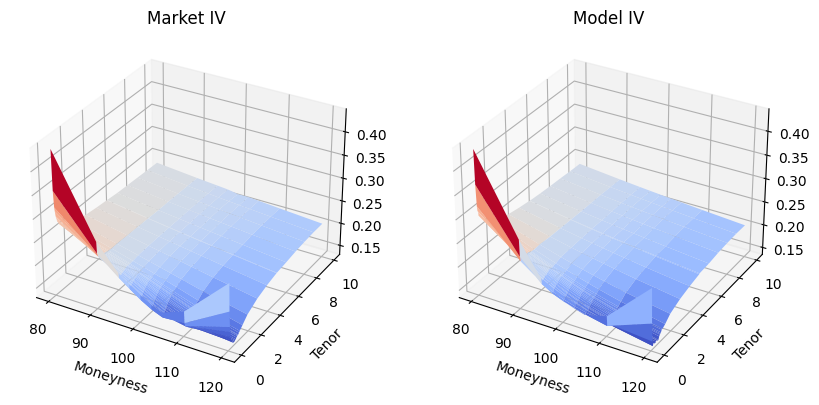

In [14]:
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, model_vol, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
#ax2.set_zlabel('IV Calibrated')
ax2.set_title('Model IV')

plt.show()